# Vehicle Detection and Tracking 

***
In this project, the goal is to write a software pipeline to identify vehicles in a video from a front-facing camera on a car. 

***
Steps:
* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply the distortion correction to the raw image.  
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view"). 
* Detect lane pixels and fit to find lane boundary.
* Determine curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Data Exploration

Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


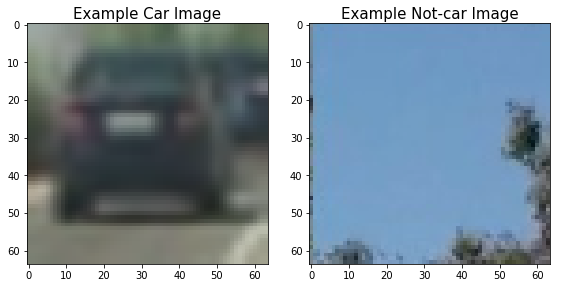

In [1]:
%matplotlib inline 
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time

# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict

#from skimage.feature import hog
#from skimage import color, exposure
# images are divided up into vehicles and non-vehicles
notcars = glob.glob('data/non-vehicles/*/*.png')
cars = glob.glob('data/vehicles/*/*.png')

data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])

# Just for fun choose random car / not-car indices and plot example images   
car_ind = 0 #np.random.randint(0, len(cars))
notcar_ind =0 # np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

# Plot the examples
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8))
f.tight_layout()
ax1.imshow(car_image)
ax1.set_title('Example Car Image', fontsize=15)
ax2.imshow(notcar_image)
ax2.set_title('Example Not-car Image', fontsize=15)

## Feature Extraction Helper Functions

In [12]:
# Jupyter notebook inline drawing

import pickle
import numpy as np
import cv2
import matplotlib.image as mpimg
from skimage.feature import hog
from scipy.ndimage.measurements import label
import glob
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import time
from scipy.ndimage.measurements import label


def convert_color(img, conv='RGB2YCrCb'):
    # apply color conversion if other than 'RGB'
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    elif conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    elif conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    elif conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    elif conv == 'RGB2HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    elif conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    else:
        return np.copy(img)      
 

class bbox():
    """
    Class to contain all vehicle detection classifier features. 
    """

    def __init__(self):
        # Parameters of image spatial and color histogram features 
        self.spatial_size = 16
        self.histbin = 10
        self.hist_range = (50,256)
        
        # Parameters of HOG features 
        self.colorspace = 'RGB2YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
        self.orient = 16
        self.pix_per_cell = 8
        self.cell_per_block = 2
        
        # Classifier
        self.svc = None
        self.X_scaler = None
        
        # Only search the lower part of image
        self.xstart = 0
        self.xstop = 1280
        self.ystart = 400
        self.ystop = 656
        
        # Smaller window
        self.xstart_s = 150
        self.xstop_s = 1130
        self.ystart_s = 400
        self.ystop_s = 520
        
        # History heatmap
        self.heatmap_his = []
        self.len_heatmp_history = 3
        
        # Small scale threshold (to shrink search area with that scale)
        self.small_scale_threshold = 1.6
        
        # Prediction confidence threshold (To reject false positive at very beginning)
        self.pred_confidence_threshold = 0.9


    def get_hog_features(self, img, orient, pix_per_cell, cell_per_block, 
                            vis=True, feature_vec=True):
        """
        # HoG feature extraction.
        # Call with two outputs if vis==True
        """
        if vis == True:
            features, hog_image = hog(img, orientations=orient, 
                                      pixels_per_cell=(pix_per_cell, pix_per_cell),
                                      cells_per_block=(cell_per_block, cell_per_block), 
                                      transform_sqrt=False, 
                                      visualise=vis, feature_vector=feature_vec)
            return features, hog_image
        # Otherwise call with one output
        else:      
            features = hog(img, orientations=orient, 
                           pixels_per_cell=(pix_per_cell, pix_per_cell),
                           cells_per_block=(cell_per_block, cell_per_block), 
                           transform_sqrt=False, 
                           visualise=vis, feature_vector=feature_vec)
            return features
    
    def bin_spatial(self, img, size=(32, 32)):
        """
        # Define a function to compute binned color features  
        """
        # Use cv2.resize().ravel() to create the feature vector
        features = cv2.resize(img, size).ravel() 
        # Return the feature vector
        return features
    
    def color_hist(self, img, nbins=32, bins_range=(0, 256)):
        """
        # Define a function to compute color histogram features  
        """
        # Compute the histogram of the color channels separately
        channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
        channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
        channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
        # Concatenate the histograms into a single feature vector
        hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
        # Return the individual histograms, bin_centers and feature vector
        return hist_features
    
    def extract_features(self, imgs):
        """
        # Define a function to extract features from a list of images
        # Have this function call bin_spatial(), color_hist() and get_hog_features().
        """
        # Create a list to append feature vectors to
        features = []
        # Iterate through the list of images
        for file in imgs:
            # Read in each one by one
            image = cv2.imread(file)
            
            # apply color conversion 
            feature_image = convert_color(image, conv=self.colorspace)
            
            # Apply bin_spatial() to get spatial color features
            spatial_features = self.bin_spatial(feature_image, size=(self.spatial_size,self.spatial_size))
            print("spatial_features.shape: ",spatial_features.shape)
            
            # Apply color_hist() also with a color space option now
            hist_features = self.color_hist(feature_image, nbins=self.histbin, bins_range=self.hist_range)
            print("hist_features.shape: ", hist_features.shape)
            
            # Compute individual channel HOG features for the entire image
            hog1 = self.get_hog_features(feature_image[:,:,0], self.orient, self.pix_per_cell, self.cell_per_block, feature_vec=False)
#             hog2 = self.get_hog_features(feature_image[:,:,1], self.orient, self.pix_per_cell, self.cell_per_block, feature_vec=False)
#             hog3 = self.get_hog_features(feature_image[:,:,2], self.orient, self.pix_per_cell, self.cell_per_block, feature_vec=False)
    
#             hog_features = np.hstack((hog1, hog2, hog3)).reshape(-1,)
            hog_features = hog1
            
            print("hog_features.shape: ", hog_features.shape)

            # Append the new feature vector to the features list
            features.append(np.concatenate((spatial_features, hist_features, hog_features)))
        
        # Return list of feature vectors
        return features
    

    def train_svm(self, cars, notcars):
        
        """
        Training linear SVM classifier
        """
        # Extract features from labeled dataset
        car_features = self.extract_features(cars)        
        notcar_features = self.extract_features(notcars)        

        # Create an array stack of feature vectors
        X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
        # Fit a per-column scaler
        X_scaler = StandardScaler().fit(X)
        # Apply the scaler to X
        scaled_X = X_scaler.transform(X)
        
        # Define the labels vector
        y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
        
        # Split up data into randomized training and test sets
        rand_state = np.random.randint(0, 100)
        
        X_train, X_test, y_train, y_test = train_test_split(
            scaled_X, y, test_size=0.2, random_state=rand_state)
        
        print('Using spatial binning of:',self.spatial_size,'and', self.histbin,'histogram bins')
        print('Number of training data:',len(y_train), 'testing data:', len(y_test))
        print('Feature vector length:', len(X_train[0]))
        
        # Use a linear SVC 
        svc = LinearSVC()
        # Check the training time for the SVC
        t=time.time()
        svc.fit(X_train, y_train)
        t2 = time.time()
        print(round(t2-t, 2), 'Seconds to train SVC...')
        # Check the score of the SVC
        print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
        # Check the prediction time for a single sample
        t=time.time()
        n_predict = 10
        print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
        print('For these',n_predict, 'labels: ', y_test[0:n_predict])
        t2 = time.time()
        print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
        
        # Save trained parameters to pickle file
        dist_pickle = {}
        dist_pickle["svc"] = svc
        dist_pickle["scaler"] = X_scaler
        self.save_param(dist_pickle)

    def save_param(self, dist_pickle={}):
        """
        # SVM classifier parameters
        # Save to pickle file
        """
        pickle_file = open("svc_pickle.p", 'wb')
        pickle.dump(dist_pickle, pickle_file)

    def get_param(self, pickle_file='svc_pickle.p'):
        """
        # Retrieve saved classifier parameters
        """
        dist_pickle = pickle.load(open(pickle_file, "rb" ) )
        self.svc = dist_pickle["svc"]
        self.X_scaler = dist_pickle["scaler"]


    def find_cars(self, img, scale, bbox_list=[]):
        """
        # A function that extracts features using hog sub-sampling and make predictions
        # using pre-trained SVM classifier.
        """
        
        if scale<self.small_scale_threshold:
            img_tosearch = img[self.ystart_s:self.ystop_s,self.xstart_s:self.xstop_s,:]
        else:
            img_tosearch = img[self.ystart:self.ystop,:,:]

        ctrans_tosearch = convert_color(img_tosearch, conv=self.colorspace)
        print(np.max(ctrans_tosearch))
        if scale != 1:
            imshape = ctrans_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
            
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    
        # Define blocks and steps as above
        nxblocks = (ch1.shape[1] // self.pix_per_cell)-1
        nyblocks = (ch1.shape[0] // self.pix_per_cell)-1 
        nfeat_per_block = self.orient*self.cell_per_block**2
        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // self.pix_per_cell)-1 
        cells_per_step = 2  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step
        print(nxsteps)
        print(nysteps)
        
        # Compute individual channel HOG features for the entire image
        hog1 = self.get_hog_features(ch1, self.orient, self.pix_per_cell, self.cell_per_block, feature_vec=False)
        #hog2 = self.get_hog_features(ch2, self.orient, self.pix_per_cell, self.cell_per_block, feature_vec=False)
        #hog3 = self.get_hog_features(ch3, self.orient, self.pix_per_cell, self.cell_per_block, feature_vec=False)
        
        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                #hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                #hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                #hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
                hog_features = hog_feat1
    
                xleft = xpos*self.pix_per_cell
                ytop = ypos*self.pix_per_cell
    
                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
              
                # Get color features
                spatial_features = self.bin_spatial(subimg, size=(self.spatial_size, self.spatial_size))
                hist_features = self.color_hist(subimg, nbins=self.histbin, bins_range=self.hist_range)
                #print(hog_features.shape, spatial_features.shape, hist_features.shape)
    
                # Scale features and make a prediction
                tmp = np.hstack((spatial_features, hist_features, hog_features)).astype(np.float64) 
                #print(tmp.shape)
                test_features = self.X_scaler.transform(tmp.reshape(1,-1))     
                test_prediction = self.svc.predict(test_features)
                test_confidence = self.svc.decision_function(test_features)
         
                # Safeguard using prediction confidence to eliminate false positive 
                # At very beginning
                if (test_prediction==1) and (test_confidence>self.pred_confidence_threshold):
                    #print(test_confidence)
                    if scale<self.small_scale_threshold:
                        xbox_left = self.xstart_s+np.int(xleft*scale)
                        ytop_draw = self.ystart_s+np.int(ytop*scale)
                    else:
                        xbox_left = self.xstart+np.int(xleft*scale)
                        ytop_draw = self.ystart+np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    top_left = (xbox_left, ytop_draw)
                    bottom_right = (xbox_left+win_draw,ytop_draw+win_draw)
                    bbox_list.append((top_left, bottom_right))
                    
        return bbox_list
    

    def add_heat(self, heatmap, bbox_list):
        # Iterate through list of bboxes
        for box in bbox_list:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    
        # Return updated heatmap
        return heatmap# Iterate through list of bboxes
        
    def apply_threshold(self, heatmap, threshold):
        # History list full
        len_heatmap_his = len(self.heatmap_his)
        #print(np.sum(heatmap))
        if len_heatmap_his>self.len_heatmp_history:
            # Remove oldest hist data
            self.heatmap_his.pop(0)
        # Add latest data into the list
        self.heatmap_his.append(heatmap)
        #print(np.sum(self.heatmap_his))

        # Accumulate over history
        acc_heatmap = np.zeros_like(heatmap)
        for cur_heatmap in self.heatmap_his:
            acc_heatmap += cur_heatmap
            print(np.max(cur_heatmap), np.max(acc_heatmap))

        # Zero out pixels below the threshold
        acc_heatmap[acc_heatmap <= threshold] = 0
        # Return thresholded map
        return acc_heatmap
    
    def draw_bboxes(self, img, bbox_list):
        # Iterate through all detected cars
        for bbox in bbox_list:
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0,255,0), 1)
        # Return the image
        return img

    def draw_labeled_bboxes(self, img, labels):
        # Iterate through all detected cars
        for car_number in range(1, labels[1]+1):
            # Find pixels with each car_number label value
            nonzero = (labels[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            # If box is too small, it must be a false positive
            THRESHOLD = 48 # pixels
            if ( (bbox[1][0]-bbox[0][0])<THRESHOLD or (bbox[1][1]-bbox[0][1])<THRESHOLD ):
                continue
            else:
                # Draw the box on the image
                cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        # Return the image
        return img


In [13]:
# create the bbox instance
bbox = bbox()

## Feature Extraction

(768,)
(30,)
(768,)
(30,)


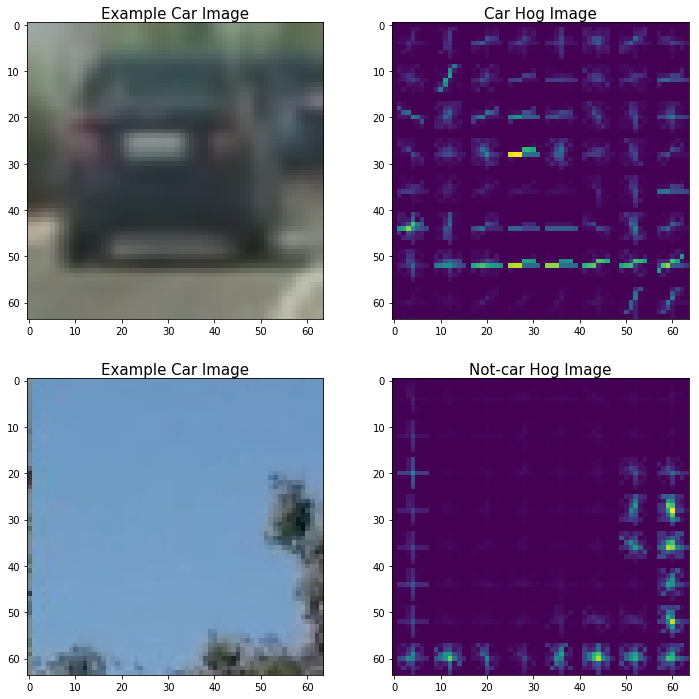

In [14]:
#car:
# apply color conversion 
feature_image = convert_color(car_image, conv='RGB2YCrCb')

# Apply bin_spatial() to get spatial color features
spatial_features = bbox.bin_spatial(feature_image, size=(bbox.spatial_size,bbox.spatial_size))
print(spatial_features.shape)

# Apply color_hist() also with a color space option now
hist_features = bbox.color_hist(feature_image, nbins=bbox.histbin, bins_range=bbox.hist_range)
print(hist_features.shape)

# Compute individual channel HOG features for the entire image
hog1, hog1_vis = bbox.get_hog_features(feature_image[:,:,0], bbox.orient, bbox.pix_per_cell, bbox.cell_per_block, feature_vec=False)
hog2, hog2_vis= bbox.get_hog_features(feature_image[:,:,1], bbox.orient, bbox.pix_per_cell, bbox.cell_per_block, feature_vec=False)
hog3, hog3_vis= bbox.get_hog_features(feature_image[:,:,2], bbox.orient, bbox.pix_per_cell, bbox.cell_per_block, feature_vec=False)

f, axarr = plt.subplots(2, 2, figsize=(12, 12))
axarr[0,0].imshow(car_image)
axarr[0,0].set_title('Example Car Image', fontsize=15)
axarr[0,1].imshow(hog1_vis)
axarr[0,1].set_title('Car Hog Image', fontsize=15)

#car:
# apply color conversion 
feature_image = convert_color(notcar_image, conv=bbox.colorspace)

# Apply bin_spatial() to get spatial color features
spatial_features = bbox.bin_spatial(feature_image, size=(bbox.spatial_size,bbox.spatial_size))
print(spatial_features.shape)

# Apply color_hist() also with a color space option now
hist_features = bbox.color_hist(feature_image, nbins=bbox.histbin, bins_range=bbox.hist_range)
print(hist_features.shape)

# Compute individual channel HOG features for the entire image
hog1, hog1_vis = bbox.get_hog_features(feature_image[:,:,0], bbox.orient, bbox.pix_per_cell, bbox.cell_per_block, feature_vec=False)
hog2, hog2_vis= bbox.get_hog_features(feature_image[:,:,1], bbox.orient, bbox.pix_per_cell, bbox.cell_per_block, feature_vec=False)
hog3, hog3_vis= bbox.get_hog_features(feature_image[:,:,2], bbox.orient, bbox.pix_per_cell, bbox.cell_per_block, feature_vec=False)

axarr[1,0].imshow(notcar_image)
axarr[1,0].set_title('Example Car Image', fontsize=15)
axarr[1,1].imshow(hog1_vis)
axarr[1,1].set_title('Not-car Hog Image', fontsize=15)
plt.savefig('output_images/hog_RGB2YCrCb')

In [ ]:
car_features = bbox.extract_features(cars)
# notcar_features = bbox.extract_features(notcars)

spatial_features.shape:  (768,)
hist_features.shape:  (30,)
hog_features.shape:  (6,)
spatial_features.shape:  (768,)
hist_features.shape:  (30,)
hog_features.shape:  (6,)
spatial_features.shape:  (768,)
hist_features.shape:  (30,)
hog_features.shape:  (6,)
spatial_features.shape:  (768,)
hist_features.shape:  (30,)
hog_features.shape:  (6,)
spatial_features.shape:  (768,)
hist_features.shape:  (30,)
hog_features.shape:  (6,)
spatial_features.shape:  (768,)
hist_features.shape:  (30,)
hog_features.shape:  (6,)
spatial_features.shape:  (768,)
hist_features.shape:  (30,)
hog_features.shape:  (6,)
spatial_features.shape:  (768,)
hist_features.shape:  (30,)
hog_features.shape:  (6,)
spatial_features.shape:  (768,)
hist_features.shape:  (30,)
hog_features.shape:  (6,)
spatial_features.shape:  (768,)
hist_features.shape:  (30,)
hog_features.shape:  (6,)
spatial_features.shape:  (768,)
hist_features.shape:  (30,)
hog_features.shape:  (6,)
spatial_features.shape:  (768,)
hist_features.shape:  

## Train SVM Classifier

In [ ]:
bbox.train_svm(cars, notcars)

## Sliding Window Search

In [ ]:
bbox.get_param()

# Bounding box list to save box (x,y) in sliding windowed searching
bbox_list=[]

images = glob.glob('examples/*')

test_scales = [1.6,1.3,2.0,2.2]

fig = plt.figure(figsize=(25,25))
for idx, f in enumerate(images):
    img = mpimg.imread(f)
    for scale in test_scales:
        bbox_list = bbox.find_cars(img, scale, bbox_list)
        out_img = bbox.draw_bboxes(img,bbox_list)
        a = fig.add_subplot(1,6,idx+1)
        a.axis('off')
        plt.imshow(out_img)
        bbox_list=[]

## Heatmap and labelledbounding box

In [ ]:
### Heatmap and labelledbounding box

# Heat map
heat = np.zeros_like(img[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = bbox.add_heat(heat,bbox_list)

# Apply threshold to help remove false positives
heat = bbox.apply_threshold(heat,0)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Label bounding box
# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = bbox.draw_labeled_bboxes(np.copy(img), labels)

# Show heat map
plt.imshow(heatmap)
plt.show()

# Show labelled image
plt.imshow(draw_img)
plt.show()
plt.savefig('output_images/sliding_window_1')

## Test on Videos

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
# Vehicle detection pipeline
def bbox_pipeline(bbox, img, bbox_list=[]):
    '''
    Processing vehicle detection and bounding box.
    '''
    img = np.copy(img)

    # Do multi-scale searching
    scale = 1.0
    bbox_list = bbox.find_cars(img, scale, bbox_list)
    scale = 1.5
    bbox_list = bbox.find_cars(img, scale, bbox_list)
    scale = 2.0
    bbox_list = bbox.find_cars(img, scale, bbox_list)
    
    ### Heatmap and labelledbounding box
    # Heat map
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = bbox.add_heat(heat,bbox_list)
    # Apply threshold to help remove false positives
    heat = bbox.apply_threshold(heat,5)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    
    # Label bounding box
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    img = bbox.draw_bboxes(img, bbox_list)
    draw_img = bbox.draw_labeled_bboxes(img, labels)
    # To view the heatmap boxes?
    #draw_img = np.array(np.dstack((heatmap, heatmap, heatmap))*255, dtype='uint8')
    # Alpha blending
    draw_img = cv2.addWeighted(draw_img, 0.9, img, 0.1, 0) 

    # Searching window (big and small)
    s_win = ((bbox.xstart_s,bbox.ystart_s), (bbox.xstop_s,bbox.ystop_s))
    b_win = ((bbox.xstart,bbox.ystart), (bbox.xstop,bbox.ystop))
    cv2.rectangle(draw_img, s_win[0], s_win[1], (0,0,255), 2)
    cv2.rectangle(draw_img, b_win[0], b_win[1], (0,0,255), 2)

    return draw_img

In [ ]:
project_output = 'project_output.mp4'
FILE = 'test_video.mp4'
# clip = VideoFileClip("test_video.mp4")
# # clip = VideoFileClip("project_video.mp4")

# white_clip = clip.fl_image(bbox_pipeline) #NOTE: this function expects color images!!
# %time white_clip.write_videofile(project_output, audio=False)

clip = cv2.VideoCapture(FILE)
fourcc = cv2.VideoWriter_fourcc(*'X264')

frame_cnt = 0
frame_start = 0
frame_end = 0xffffffff
#frame_end = 50

out=None

# Vehicle detector
bbox.get_param()
bbox_list = []

# Search as if from start of frame
detected = False

while True:
    flag, image = clip.read()
    bbox_list = []
    if flag:
        frame_cnt += 1
        if frame_cnt < frame_start:
            continue
        elif frame_cnt > frame_end:
            break
        print('frame_cnt = ', frame_cnt)
        if out == None:
            out = cv2.VideoWriter(project_output, fourcc, 30.0, (image.shape[1]//2, image.shape[0]//2))

        # Vehicle detection pipeline
        res = bbox_pipeline(bbox, image, bbox_list)

        # Resize
        res = cv2.resize(res, (res.shape[1]//2, res.shape[0]//2))
        # Write video out
        cv2.imshow('video', res)
        out.write(res)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break




In [ ]:
project_output